# CNN Approach to Time-series classification

In this notebook we demonstrate a transformation-based approach to time series classification. A time-series is transformed into an image by one of several methods and the classifier is trained directly on the image data.

The notebook automates preprocess of data on any of the 128 UCR time series classification datasets. Download here:
http://www.timeseriesclassification.com/index.php, unzip, and set your pwd there to run this notebook as is.

In [1]:
from scipy.io import arff
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from fastai import *
from fastai.vision import * 
from fastai.vision.data import ImageDataBunch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pyts.image import GASF, GADF, MTF, RecurrencePlots
import pdb
from skimage.transform import resize

In [2]:
import fastai
import warnings
warnings.filterwarnings('ignore')
fastai.__version__

'1.0.24'

In [3]:
def cleanup(df):
    #df.sample(df.shape[0], replace=False).reset_index(drop=True)
    df.columns = [k for k in range(df.shape[1]-1)]+['target']
    for k in df.columns[:-1]:
        df[k] = df[k].astype('float')
    if df.target.dtype == 'object':
        df['target'] = df['target'].apply(lambda x: x.decode('ascii')).astype('int')
    if sorted(df.target.unique()) != list(np.arange(df.target.nunique())):
        new_targs = pd.DataFrame({'target':df.target.unique()}).reset_index()
        df = pd.merge(df, new_targs, left_on='target', right_on='target').drop('target',axis=1).rename(columns={'index':'target'})
    ts = pd.melt(df.reset_index(), id_vars=['index','target'], var_name='time').rename(columns={'index':'id'})
    ts = ts.groupby(['id','time','target']).value.mean().reset_index()
    return df, ts

def graph_ts(ts):
    for k in ts.target.unique():
        fig, axes = plt.subplots(figsize=(15,5))
        sns.tsplot(ts[ts.target == k], time='time', unit='id', condition='target', value='value', err_style='unit_traces', ax=axes)    
    fig, axes = plt.subplots(figsize=(15,5))
    sns.tsplot(ts, time='time', unit='id', condition='target', value='value', err_style='unit_traces', ax=axes)
    return None

def prep_data(task='Oliveoil', cmap='rainbow', method='GASF', image_size=224):
    path = Path('TSC/%s'%(task))
    for phase in ['TRAIN','TEST']:
        data = arff.loadarff('TSC/%s_%s.arff'%(task,phase))
        df = pd.DataFrame(data[0])
        df, ts = cleanup(df)
        graph_ts(ts)
        labels = df.target.unique()
        if method == 'GASF':
            transformer = GASF(image_size=image_size)
        elif method == 'GADF':
            transformer = GADF(image_size=image_size)
        elif method == 'MTF':
            transformer = MTF(image_size=image_size)
        elif method == 'RP':
            transformer = RecurrencePlots(dimension=1, epsilon=None, percentage=10)
        else:
            method = 'Unaltered'
        method_path = path/f'{method}'
        method_path.mkdir(exist_ok=True)
        phase_path = method_path/f'{phase}'
        phase_path.mkdir(exist_ok=True)
        if method != 'Unaltered':
            image_data = transformer.fit_transform(df[df.columns[:-1]])
            image_data = resize(image_data, (image_data.shape[0],image_size,image_size))
            for label in labels:
                label_path = phase_path/f'{label}'
                label_path.mkdir(exist_ok=True)
                sub_df = df[df.target == label]
                idxs = sub_df.index
                for idx in idxs:
                    plt.imsave(label_path/f'{idx}.png', image_data[idx], cmap=cmap)
        else: 
            for label in labels:
                label_path = phase_path/f'{label}'
                label_path.mkdir(exist_ok=True)
                sub_df = df[df.target == label]
                idxs = sub_df.index
                for idx in idxs:
                    plt.figure(figsize=(10,10))
                    plt.plot(df.iloc[idx].values)
                    plt.savefig(label_path/f'{idx}')
                    plt.close('all')    
    return None



In [4]:
task='OliveOil'
method = 'RP'

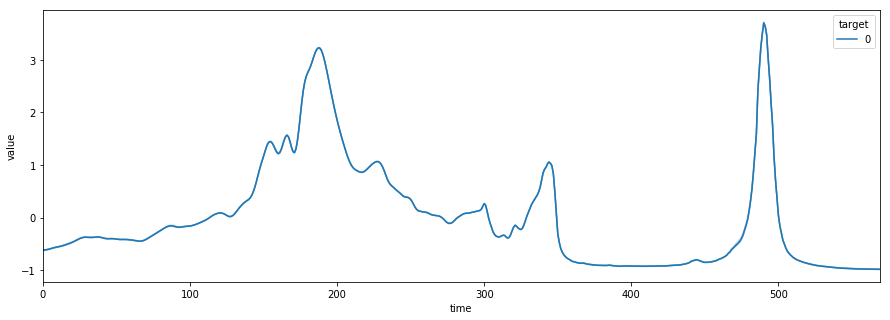

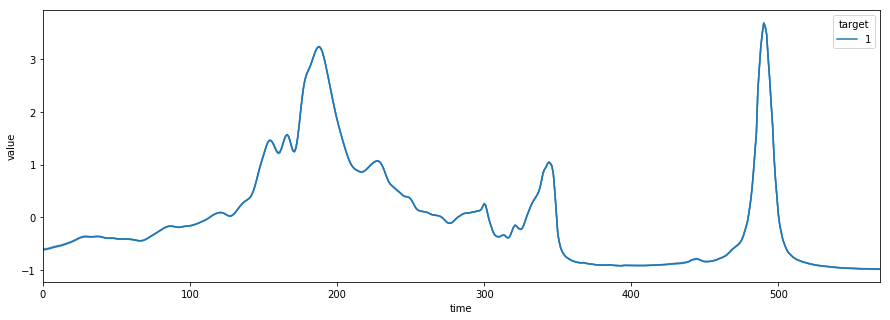

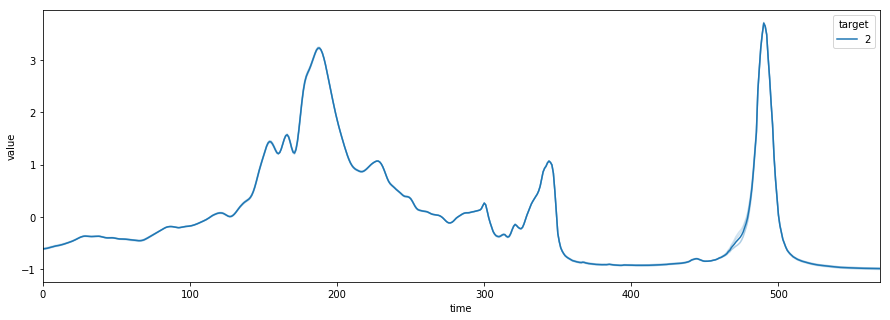

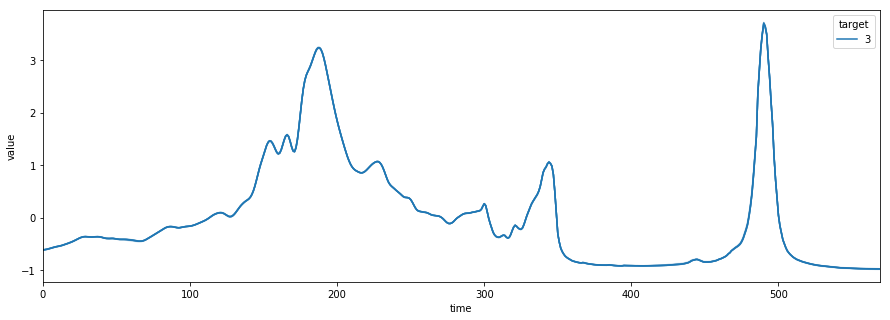

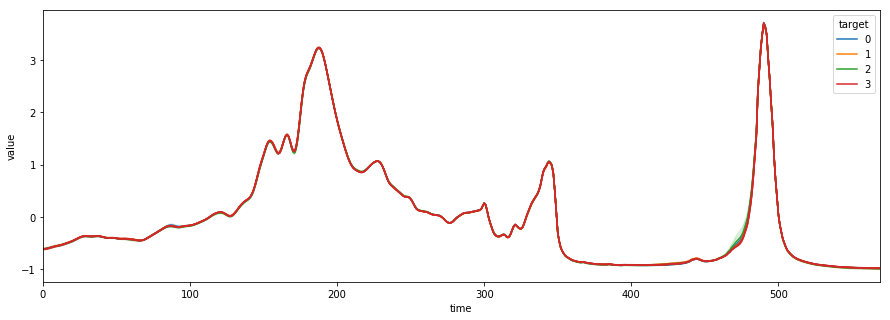

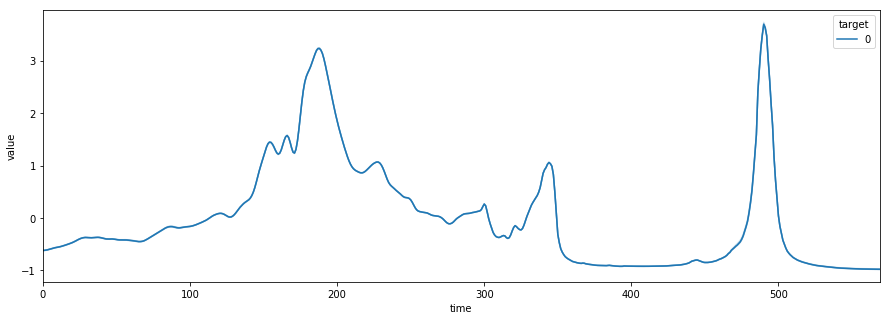

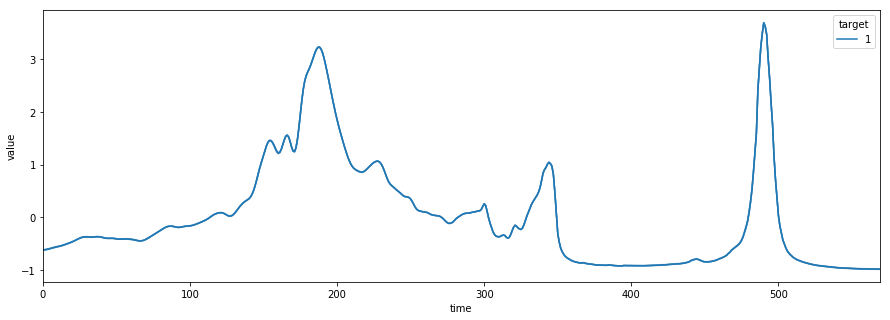

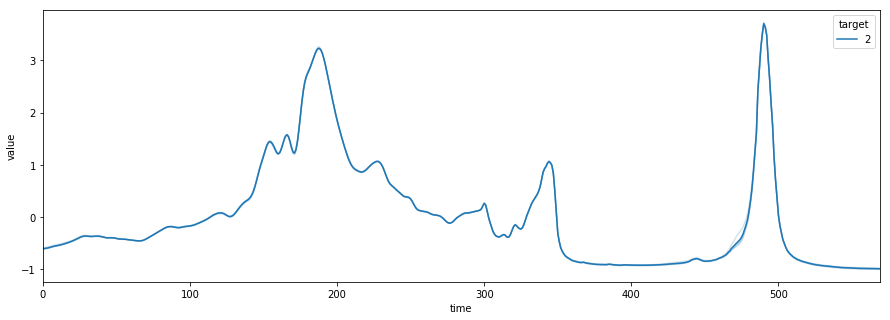

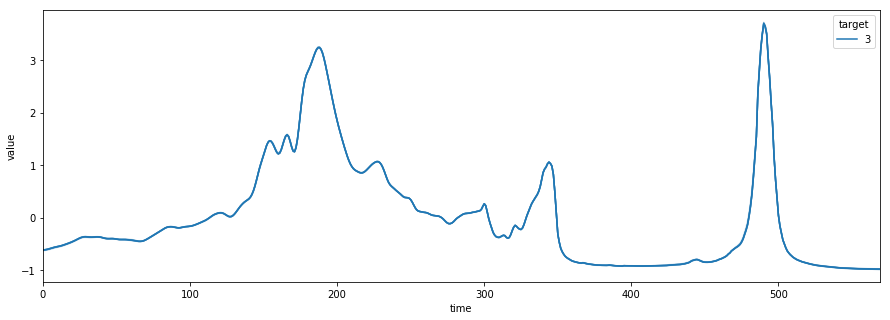

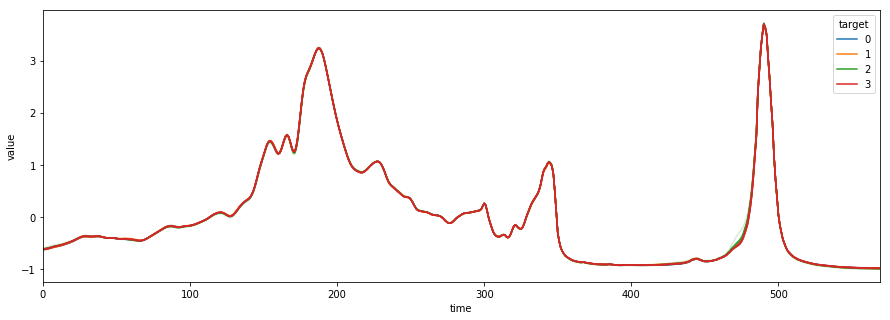

In [5]:
prep_data(task=task, method=method, image_size=128)

In [6]:
path = Path('TSC/%s/%s'%(task,method))
data = (ImageItemList.from_folder(path) 
        .split_by_folder(train='TRAIN', valid='TEST')
        .label_from_folder()
        .transform().databunch(bs=32))

In [7]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


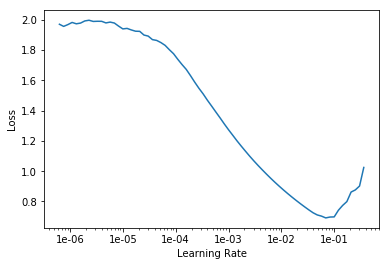

In [8]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=3e-3)

In [ ]:
learn.unfreeze() ; learn.lr_find() ; learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr = 3e-3)

In [9]:
class stacked_resnet_cores(nn.Module):
    def __init__(self, dummy_databunch, num_images):
        super().__init__()
        self.resnets = [list(create_cnn(dummy_databunch, models.resnet34).model.children())[0] for _ in range(num_images)]
        self.resnets = torch.nn.ModuleList(self.resnets)
        
    def forward(self, x):
        outputs = []
        for k,j in enumerate(self.resnets):
            output = self.resnets[k](x[:,k*3:(k+1)*3,:,:])
            outputs.append(output)
        output = torch.cat(outputs, dim=1)
        return output

In [10]:
class multi_image_dataset(Dataset):
    def __init__(self, paths, train=False, valid=False):
        self.x = []
        if train:
            for path in paths:
                data = (ImageItemList.from_folder(path) 
                        .split_by_folder(train='TRAIN', valid='TEST')
                        .label_from_folder()
                       ).train
                out = torch.cat([data[k][0].data.unsqueeze(-1) for k in range(len(data))], dim=-1)
                self.x.append(out)
        elif valid:
            for path in paths:
                data = (ImageItemList.from_folder(path) 
                        .split_by_folder(train='TRAIN', valid='TEST')
                        .label_from_folder()
                        ).valid
                out = torch.cat([data[k][0].data.unsqueeze(-1) for k in range(len(data))], dim=-1)
                self.x.append(out)
        self.x = torch.cat(self.x, dim=0)
        self.y = data.y
        self.length = out.size(-1)
        
    def __len__(self):
        return self.length
        
    
    def __getitem__(self, idx):
        return self.x[:,:,:,idx], torch.Tensor([int(self.y[idx].cat)]).long()

In [11]:
methods = ['GADF', 'RP']
#for method in methods:
#    prep_data(task=task, method=method, image_size=224)
paths = [Path('TSC/%s/%s'%(task,method)) for method in methods]

In [12]:
tr_ds = multi_image_dataset(paths, train=True)
val_ds = multi_image_dataset(paths, valid=True)

In [13]:
tr_dl = DataLoader(tr_ds, batch_size = 16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 16, shuffle=True)
md = DataBunch(tr_dl, val_dl)

In [20]:
crit = nn.CrossEntropyLoss()
arch = stacked_resnet_cores(data, 2)

In [21]:
x,y = next(iter(val_dl))

In [22]:
x.size()

torch.Size([16, 6, 128, 128])

In [23]:
arch(x)

RuntimeError: Expected object of backend CPU but got backend CUDA for argument #2 'weight'

In [24]:
arch.cpu(); arch(x)

tensor([[[[0.0009, 0.0473, 0.0000, 0.0000],
          [0.0543, 0.0000, 0.0710, 0.0295],
          [0.7225, 0.2399, 0.1971, 0.0031],
          [0.2505, 0.0867, 0.0515, 0.0000]],

         [[1.2608, 1.3426, 0.4119, 0.1579],
          [1.9721, 2.0900, 0.7484, 0.5102],
          [0.9925, 0.8528, 0.0000, 0.0478],
          [0.1773, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.4336, 0.7287, 0.4048],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         ...,

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.2514, 0.4215, 0.1231],
          [0.0000, 0.0000, 0.0000, 0.0843]],

         [[0.0588, 0.3182, 0.8318, 0.4942],
          [1.1192, 1.1200, 1.1853, 0.3189],
          [0.6205, 0.0000, 0.1244, 0.6457],
          [0.8272, 0.3455, 0.3401, 0.5108]],

         [[0.4252, 0.3235, 0.3145, 1.5684],
          [0.3224, 0.0000, 0.1147, 1.3185],
       

In [25]:
y = _ ; y.size()

torch.Size([16, 1024, 4, 4])

## But again whenever I put the guy on GPU it didn't work anymore....

In [27]:
arch.cuda(); arch(x)

RuntimeError: Expected object of backend CPU but got backend CUDA for argument #2 'weight'